## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [4]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

In [2]:
# custom imports
import a_star
import logging
mylogger = logging.getLogger()
mylogger.setLevel(logging.DEBUG)

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

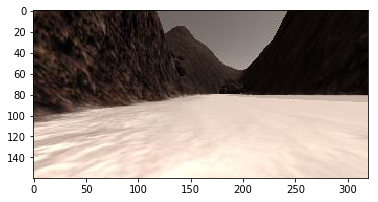

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

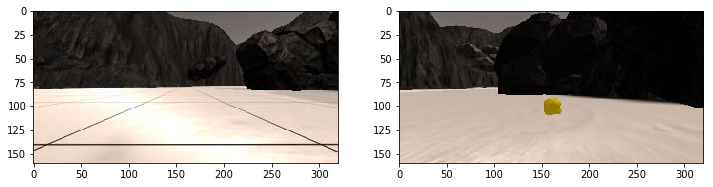

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Write function that will give polar coordinates from any abitrary point to any arbitrary point

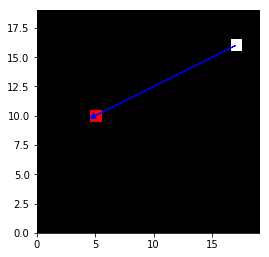

In [5]:
def to_polar_coords_with_origin(origin_x, origin_y, x_pixels, y_pixels):
    y_diffs = y_pixels - float(origin_y)
    x_diffs = x_pixels - float(origin_x)
    # Calculate the distances between the origin and the pixels
    dist = np.sqrt((y_diffs ** 2) + (x_diffs ** 2))
    angles = np.arctan2(y_diffs, x_diffs)
    return dist, angles

test_map = np.zeros((20,20,4), dtype=np.uint8)

dummy_x_origin = 17
dummy_y_origin = 16
test_map[dummy_y_origin, dummy_x_origin] = (255, 255, 255, 1)

dummy_destination_x = 5
dummy_destination_y = 10
test_map[dummy_destination_y, dummy_destination_x] = (255, 0, 0, 2)

# test_map
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(test_map[:,:,:3])
plt.ylim(0, 19)
plt.xlim(0, 19)

# test out the function
distance_to_polar_coords_with_origin, angle_to_polar_coords_with_origin = to_polar_coords_with_origin(dummy_x_origin, dummy_y_origin, dummy_destination_x, dummy_destination_y)

# draw the result onto the testgraph

arrow_length = distance_to_polar_coords_with_origin
x_arrow = arrow_length * np.cos(angle_to_polar_coords_with_origin)
y_arrow = arrow_length * np.sin(angle_to_polar_coords_with_origin)
plt.arrow(dummy_x_origin, dummy_y_origin, x_arrow, y_arrow, color='blue', head_width=.5, head_length=.5)

## Write function that identifies the nearest unexplored point
The function will return the xy coordinates of the unexplored point nearest from the rover or reference point.

DEBUG:root:min distance 8.54400374532
DEBUG:root:x_diff -3.0
DEBUG:root:y-diff -8.0
DEBUG:root:dist ** 2 73.0
DEBUG:root:x_diff ** 2 + y_diff **2 73.0
DEBUG:root:accompanying_ angle -1.92956699707
DEBUG:root:np.arctan2(float(y_diff), x_diff) -1.92956699707
DEBUG:root:unexplored point indices (array([ 1,  2,  5, 17, 19]), array([19,  2,  7,  0, 18]))


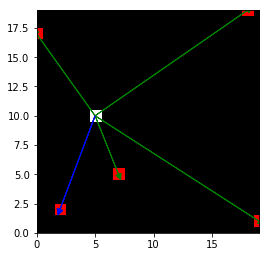

In [6]:
def choose_closest_flag(rover_xpos, rover_ypos, memory_map_mini, minimum_distance=0, flag=0):
    """
    This function returns a memory_map coordinate. The initial destination is normally chosen to be
    the nearest unexplored (untagged) point on the memory_map

    This may trigger the rover to first rotate 360 degrees upon initialization to survey what's in sight.

    :return: returns an (x,y) tuple of 2 integers. These is the destination's xy coordinates in the
    memory _ap.  Rover.memory_map is different from Rover.worldmap.  Rover.memory_map is 10 times
    larger (2000 x 2000 )and has more layers

    TODO allow the rover to choose as a destination any of the (navigable) areas it has already explored

    """
    
    assert memory_map_mini.ndim == 2, " map does not have 2 dimensions "

    unexplored_point_indices = np.where(memory_map_mini == flag)

    # The first array (index 0) are the y values.  The second one (index 1) are the x values
    y_points = unexplored_point_indices[1]
    x_points = unexplored_point_indices[0]

    # print("x_points ", len(x_points))
    # print("y_points ", len(y_points))

    distances, angles = to_polar_coords_with_origin(rover_xpos, rover_ypos, x_points, y_points)

    # Get the argmin values given a condition
    # https://seanlaw.github.io/2015/09/10/numpy-argmin-with-a-condition/
    mask = (distances >= minimum_distance)
    subset_idx = np.argmin(distances[mask])
    parent_idx = np.arange(distances.shape[0])[mask][subset_idx]

    # distance_min_idx = np.argmin(distances)
    distance_min_idx = parent_idx
    min_distance = distances[distance_min_idx]
    accompanying_angle = angles[distance_min_idx]

    x_point = x_points[distance_min_idx]
    y_point = y_points[distance_min_idx]

    chosen_destination_coords = (x_point, y_point)
    chosen_destination_distance = min_distance
    chosen_destination_angle = accompanying_angle

    x_diff = x_point - float(rover_xpos)
    y_diff = y_point - float(rover_ypos)
    
    logging.debug("min distance " + str(min_distance))
    logging.debug("x_diff " + str( x_diff))
    logging.debug("y-diff " + str( y_diff))
    logging.debug("dist ** 2 " + str((min_distance ** 2)))
    logging.debug("x_diff ** 2 + y_diff **2 " + str((x_diff ** 2) + (y_diff ** 2)))
    logging.debug("accompanying_ angle " + str(accompanying_angle))
    logging.debug("np.arctan2(float(y_diff), x_diff) " + str(np.arctan2(float(y_diff),  x_diff)))

    
#     assert (float(min_distance ** 2) == float((x_diff ** 2) + (y_diff ** 2)))
    c_squared = (min_distance) ** 2
    a_squared = (x_diff ** 2)
    b_squared = (y_diff ** 2)
    assert np.isclose(c_squared, a_squared + b_squared, rtol=1e-05, atol=1e-08, equal_nan=False)
    assert np.isclose((accompanying_angle), np.arctan2(float(y_diff), x_diff))

    return chosen_destination_coords, chosen_destination_distance, chosen_destination_angle

# create a mini "world" map. The 4th layer indicate the areas that have been visited.
# 0 = area unexplored/uncharted
# 5 = area is an obstacle
# 6 = area has a rock sample
# 7 = area is navigable terrain
# 8 = extra indicator for other possible purposes
memory_map_mini = np.zeros([20, 20, 4], dtype=np.uint8)

# plot the exploration status for the map, keep the colors black
upper_left_red = memory_map_mini[:10, :10] = (0, 0, 0, 5)
upper_right_green = memory_map_mini[:10, 10:] = (0, 0, 0, 6)
lower_left_blue = memory_map_mini[10:, :10] = (0, 0, 0, 7)
lower_right_white = memory_map_mini[10:, 10:] = (0,0, 0, 8)

# upper_left_red = memory_map_mini[:10, :10] = (255, 0, 0, 5)
# upper_right_green = memory_map_mini[:10, 10:] = (0, 255, 0, 6)
# lower_left_blue = memory_map_mini[10:, :10] = (0, 0, 255, 7)
# lower_right_white = memory_map_mini[10:, 10:] = (255,255, 255, 8)

# create dummy rover position data for to_polar_coords with origin
dummy_rover_xpos = 5
dummy_rover_ypos = 10

# plot the rover location, color it white
memory_map_mini[dummy_rover_ypos, dummy_rover_xpos] = (255, 255, 255, 1)

# assign 2 pixels as unexplored, plot and color them red
unexplored_area1 = memory_map_mini[19, 18] = (255, 0, 0, 0)
unexplored_area2 = memory_map_mini[5, 7] = (255, 0, 0, 0)
memory_map_mini[2, 2] = (255, 0, 0, 0)
memory_map_mini[1, 19] = (255, 0, 0, 0)
memory_map_mini[17, 0] = (255, 0, 0, 0)

# choose the mearest unexplored point that is at least 8 pixels away
chosen_destination, chosen_distance, chosen_angle = choose_closest_flag(dummy_rover_xpos, dummy_rover_ypos, memory_map_mini[:,:,3], 8)

# fetch indices of unexplored areas
unexplored_point_indices = np.where(memory_map_mini[:,:,3] == 0)

logging.debug("unexplored point indices " + str(unexplored_point_indices))
# unexplored point indices  (array([ 5, 19]), array([ 7, 18]))

# assign to x and y values
x_points = unexplored_point_indices[1]
y_points = unexplored_point_indices[0]

distances, angles = to_polar_coords_with_origin(dummy_rover_xpos, dummy_rover_ypos,x_points, y_points)


# # Do some plotting
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# f.tight_layout()
# ax1.imshow(memory_map_mini[:, :,:3])
# ax1.set_title('Without y and x limits', fontsize=40)
# ax1.tick_params(labelsize=20)

# ax2.imshow(memory_map_mini[:, :,:3])
# ax2.set_title('With limits specified', fontsize=40)
# ax2.set_ylim(0, 19)
# ax2.tick_params(labelsize=20)
# ax2.set_xlim(0, 19)

fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(memory_map_mini[:, :, :3])
plt.ylim(0, 19)
plt.xlim(0, 19)

# plot all the arrows to their respective points
for distance, angle in zip(distances, angles):
    arrow_length = distance
    x_arrow = arrow_length * np.cos(angle)
    y_arrow = arrow_length * np.sin(angle)
    plt.arrow(dummy_rover_xpos, dummy_rover_ypos, x_arrow, y_arrow, color='green', head_width=.5, head_length=.5)

# replot the arrow for the nearest point with a different color    
arrow_length = chosen_distance
x_arrow = arrow_length * np.cos(chosen_angle)
y_arrow = arrow_length * np.sin(chosen_angle)
plt.arrow(dummy_rover_xpos, dummy_rover_ypos, x_arrow, y_arrow, color='blue', head_width=.5, head_length=.5)



## Write a function that will simply compute distances between points
We are writing this function instead of simply using the `to_polar_coords_with_origin` to speed up efficiency in the functions where we will be computing distances primarily.

In [7]:
def compute_distances(origin_x, origin_y, x_points, y_points):
    y_diffs = y_points - origin_y
    x_diffs = x_points - origin_x
    # Calculate the distances between the origin and the pixels
    distances = np.sqrt((y_diffs ** 2) + (x_diffs ** 2))
    
    return distances

## Write a function to check if an obstacle is crossed by a line between 2 points
We will use this function to check if the path from point A to point B has coordinates of interest (i.e, are tagged as obstacles)

obstacles blocking the path [(5, 8)]


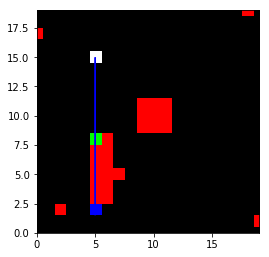

In [8]:
def get_range_to_iterate_over(origin_x, origin_y, destination_x, destination_y, angle, granularity):
    """
    angle: in radians
    """
    # set the range to begin from the lowest x value to the highest
    range_start_x = min(origin_x, destination_x) 
    range_end_x = max(origin_x, destination_x)
        
    if (0 <= abs(angle) <= np.pi/2) or (((3 * np.pi)/ 4) < abs(angle) < (np.pi * 2)):
        # print(" quadrant I or IV")
        # check from left to right
        range_to_iterate_over_x = np.arange(range_start_x, range_end_x, granularity)
    elif ((np.pi/2) < abs(angle) <= ((3 * np.pi)/ 4)): # or (((3 * np.pi)/ (np.pi * 2)) < abs(angle) <= (3 * np.pi)/ (np.pi * 4)):
        # print("quadrant II or III")
        # if the angle is more than 90 degrees, x should be from right to left
        range_to_iterate_over_x = np.arange(range_start_x, range_end_x, granularity)[::-1]
    
    # do the same for y values
    range_start_y = min(origin_y, destination_y)
#     print("range start y", range_start_y)
    range_end_y = max(origin_y, destination_y)
#     print("range end y", range_end_y)
    
    # if the angle is in the 2 upper quadrants of the cartesian plane
    if (0 <= angle <= np.pi) or (-np.pi <= angle <= -np.pi*2):
        # print("quadrant I or II")
        # check from bottom to top
        range_to_iterate_over_y = np.arange(range_start_y, range_end_y, granularity)
    # if the anlge is in the 2 bottom quadrants of the cartesian plane
    elif (np.pi < angle < np.pi * 2) or (-np.pi < angle < 0):
        # print("quadrant III or IV")
        # check from top to bottom
        range_to_iterate_over_y = np.arange(range_start_y, range_end_y, granularity)[::-1]
    
    return range_to_iterate_over_x, range_to_iterate_over_y
    

def obstacle_crossed_by_line(origin_x, origin_y, destination_x, destination_y, map_data, flag_list, granularity=1, line_width=0, return_all=False):
    """
    x_points: should be divisible by the granularity value, otherwise, this function won't detect it. This function
    can only detect coordinates whose x values are divisible by the granularity value
    map_data: should be a 2 dimensional array indicating which areas are obstacles and not
    line_width: TODO find all points traversed by a line with thickness of line_width
    return: list of (x,y) tuples
    """
    
    assert(np.ndim(map_data) == 2)
    
#     print("map_data_size: ", map_data.size)

#     print("destination x", destination_x)
#     print("desitnation y", destination_y)
#     print("this is the map data originally\n", map_data)
#     print("this is the x y value for map_data", map_data[destination_y, destination_x])
    
#     assert(map_data[destination_y, destination_x] == 0, "tag is " + str(map_data[destination_y, destination_x]) + " instead")

    # "draw" the line by getting its different elements
    x_diff = destination_x - float(origin_x) + .0001# convert one of the numbers into float so that we can have more 
    y_diff = destination_y - float(origin_y) + .0001# accurate computations, with no rounding off
    
    slope = y_diff/x_diff
    
    y_intercept = origin_y - (slope*origin_x)
    
    distance, angle = to_polar_coords_with_origin(origin_x, origin_y, destination_x, destination_y)
    
    range_to_iterate_over_x, range_to_iterate_over_y = get_range_to_iterate_over(origin_x, origin_y, destination_x, destination_y, angle, granularity) 
    
    # if x y coords are given, check each x, y coordinate pairs from x_points y_points if they are on the line    
#     print("outside ")
    if return_all is True: # run the function until all flagged coordinates that cross the line are returned
#         print("return all is true ")
        crossed_flagged_coords_x = []
        crossed_flagged_coords_y = []
        
        # check if any of the x values between the origin and destination have y_values that are obstacles
        for x in range_to_iterate_over_x:
#             ("itrating over ranges ")
            y = (slope * x) + y_intercept

            # round up and down because numpy only accepts integers when accessing array values
            # speaking of which, it may not be possible to have a granularity that is less than one
            y_up = min(np.ceil(y), map_data.shape[0])
            y_down = max(np.floor(y), 0)
            for flag in flag_list:
                if (map_data[int(y_up), int(x)] == flag):
                    crossed_flagged_coords_x.append((int(x), int(y)))
                elif (map_data[int(y_down), int(x)] == flag):
                    crossed_flagged_coords_x.append((int(x), int(y)))
        # do the same thing for y    
        for y in range_to_iterate_over_y:
            x = (y - y_intercept)/slope
            x_left = max(np.floor(x), 0)
            x_right = min(np.ceil(x), map_data.shape[1])
            for flag in flag_list:
                if map_data[int(y), int(x_left)] == flag:
                    crossed_flagged_coords_y.append((int(x_left), int(y)))
                if map_data[int(y), int(x_right)] == flag:
                    crossed_flagged_coords_y.append((int(x_right), int(y)))
                    
        # combine the crossed x and y coords with each other
        # https://stackoverflow.com/a/1319353
        crossed_flagged_coords = crossed_flagged_coords_x + list(set(crossed_flagged_coords_y) - set(crossed_flagged_coords_x))
        # no need to proceed with the rest of the function
#         print(crossed_flagged_coords)
        return crossed_flagged_coords
    else: # just return the first x or y obstacle that is encountered
        # for each flag in the list, check if they are found on the line
#         print("entering ")
        
        first_obstacle_x = None
        first_obstacle_y = None
#         print("range_to_iterate_over_y", range_to_iterate_over_y)
#         print("range_to_iterate_over_x", range_to_iterate_over_x)
        for x in range_to_iterate_over_x:
#             print("iterating x ")
            # if we already have a first obstacle, do not prceed with the loop
            if first_obstacle_x is not None:
                break
#             "reaching this space x"
#             print("x is ", x)
#             print("slope", slope)
#             print("intercept ", y_intercept)
            y = (slope * x) + y_intercept
#             print("y_result ", y)
            
            # round up and down because numpy only accepts integers when accessing array values
            # speaking of which, it may not be possible to have a granularity that is less than one
            y_up = min(np.ceil(y), map_data.shape[0])
            y_down = max(np.floor(y), 0)
            for flag in flag_list:
                if (map_data[int(y_up), int(x)] == flag):
                    first_obstacle_x = (x, int(y_up))
                    break
                elif (map_data[int(y_down), int(x)] == flag):
                    first_obstacle_x = (x, int(y_down))
                    break

        # do the same thing for y    
        for y in range_to_iterate_over_y:
#             print("iterating y", range_to_iterate_over_y)
            # if first obstacle y is not none, break the loop
            if first_obstacle_y is not None:
                break
#             print("reaching this space y")
            x = (y - y_intercept)/slope
            
#             print("y source ", y)
#             print("y_inrercept ", y_intercept)
#             print("slope ", slope)
#             print("x result ", x)
            x_left = max(np.floor(x), 0)
            x_right = min(np.ceil(x), map_data.shape[1])
            for flag in flag_list:                                                                         
                if (map_data[int(y), int(x_left)] == flag):
                    first_obstacle_y = (int(x_left), int(y))
                    break
                elif (map_data[int(y), int(x_right)].astype(int) == flag):
                    first_obstacle_y =(int(x_right), int(y))
                    break
        if first_obstacle_x and first_obstacle_y:
            # compute which obstacle is closest
            first_x_distance = compute_distances(origin_x, origin_y, first_obstacle_x[0], first_obstacle_x[1])
            first_y_distance = compute_distances(origin_x, origin_y, first_obstacle_y[0], first_obstacle_y[1])
            # return the closest obstacle as a list
            if first_x_distance >= first_y_distance:
                return [first_obstacle_y]
            elif first_y_distance > first_x_distance:
                return [first_obstacle_x]
        elif first_obstacle_x:
            return [first_obstacle_x]
        elif first_obstacle_y:
            return [first_obstacle_y]
        
#         print("first obstacle x ", first_obstacle_x)
#         print("first obstacle y ", first_obstacle_y)
    return False

multiplier = 1

# create a mini "world" map. The 4th layer indicate the areas that have been visited.
# 0 = area unexplored/uncharted
# 5 = area is an obstacle
# 6 = area has a rock sample
# 7 = area is navigable terrain
# 8 = extra indicator for other possible purposes
memory_map_mini = np.zeros([20 * multiplier, 20 * multiplier, 4], dtype=np.uint8)

# plot obstacles on the map, color them red
memory_map_mini[9 * multiplier:12 * multiplier, 9 * multiplier:12 * multiplier] = (255, 0, 0, 5)
memory_map_mini[19 * multiplier, 18 * multiplier] = (255, 0, 0, 5)
memory_map_mini[5 * multiplier, 7 * multiplier] = (255, 0, 0, 5)
memory_map_mini[2 * multiplier, 2 * multiplier] = (255, 0, 0, 5)
memory_map_mini[1 * multiplier, 19 * multiplier] = (255, 0, 0, 5)
memory_map_mini[17* multiplier, 0 * multiplier] = (255, 0, 0, 5)
memory_map_mini[3 * multiplier:9 * multiplier, 5 * multiplier:7 * multiplier] = (255, 0, 0, 5)

# create dummy rover position data for to_polar_coords with origin
dummy_rover_xpos = 5 * multiplier
dummy_rover_ypos = 15 * multiplier

# plot the rover location, color it white
memory_map_mini[dummy_rover_ypos, dummy_rover_xpos] = (255, 255, 255, 1)

# create dummy destinaton coordinates
destination_x = 5 * multiplier
destination_y = 2 * multiplier

memory_map_mini[destination_y, destination_x] = (0,0,255,8)

flag = [5]

obstacles = obstacle_crossed_by_line(dummy_rover_xpos, dummy_rover_ypos, destination_x, destination_y, memory_map_mini[:,:,3], flag, return_all=False)

print("obstacles blocking the path", obstacles)

if obstacles:
    for obstacle in obstacles:
        memory_map_mini[obstacle[1], obstacle[0]] = (0, 255,0,5)

        
        
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(memory_map_mini[:, :, :3])
plt.ylim(0, 19 * multiplier)
plt.xlim(0, 19 * multiplier)

distance, angle = to_polar_coords_with_origin(dummy_rover_xpos, dummy_rover_ypos, destination_x, destination_y)

arrow_length = distance
x_arrow = arrow_length * np.cos(angle)
y_arrow = arrow_length * np.sin(angle)
plt.arrow(dummy_rover_xpos, dummy_rover_ypos, x_arrow, y_arrow, color='blue', head_width=.5, head_length=.5)

## Choose closest unobstructed flagged point

closest unobstructed  (10, 4)
unobstructed x  10
unobstructed y  4
unobstructed point value  0


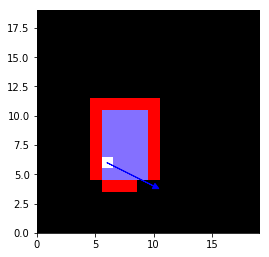

In [9]:
def choose_closest_unobstructed_point(origin_x, origin_y, map_data, flag_target=0, flag_obstruction=5, minimum_distance=0):
    # get all distances to flagged areas   
    assert map_data.ndim == 2, " map does not have 2 dimensions "

    unexplored_point_indices = np.where(map_data == flag_target)
#     print("unexplored points", unexplored_point_indices)
#     print("size ", unexplored_point_indices.size)
#     print(map_data)
    
    x_points = unexplored_point_indices[1]
    y_points = unexplored_point_indices[0]

    
#     for index in x_points:
#         print("should be zero ", map_data[y_points[index], x_points[index]])
        
#     print("x_points ", len(x_points))
#     print("y_points ", len(y_points))

    # compute the distances to them
    distances = compute_distances(origin_x, origin_y, x_points, y_points)
    
    # from lowest to highest distance, check if the path is obstructed or not

#     result = obstacle_crossed_by_line(origin_x, origin_y, x_points, y_points, map_data, [flag_obstruction])
    
#     distances = np.asarray([9,8,7,6,5,4,3,2,1])
    
    # Get the argmin values given a condition
    # https://seanlaw.github.io/2015/09/10/numpy-argmin-with-a-condition/
    mask = (distances >= minimum_distance)
    subset_idx = np.argsort(distances[mask])
    parent_idx = np.arange(distances.shape[0])[mask][subset_idx]
    
    
    closest_unobstructed_point_index = None    
    # once we have sorted them by their distances, we check if each point is obstructed
    for index in parent_idx:
#         print("this is the index ", index)
#         print("x value ", x_points[index])
#         print("y value ", y_points[index])
#         print("map_data value ", map_data[y_points[index], x_points[index]])
        
        obstruction_present = obstacle_crossed_by_line(origin_x, origin_y, x_points[index], y_points[index], map_data, [flag_obstruction], return_all=False)
        if obstruction_present:
            # if path is obstructed, do nothing
#             print("this is the obstruction ", obstruction_present)
            pass
        # if there are no obstructions, use the current index
        elif obstruction_present is False:
            closest_unobstructed_point_index = index
            break
            
    
    # use the obtained index of the unobstructed point to get its x and y coordinates
    if closest_unobstructed_point_index:
        closest_unobstructed_x_point = x_points[closest_unobstructed_point_index]
        closest_unobstructed_y_point = y_points[closest_unobstructed_point_index]
        closest_unobstructed_point = (closest_unobstructed_x_point, closest_unobstructed_y_point)
    else:
        closest_unobstructed_point = None
    
    return closest_unobstructed_point
    


    
    
    
multiplier = 1

# create a mini "world" map. The 4th layer indicate the areas that have been visited.
# 0 = area unexplored/uncharted
# 5 = area is an obstacle
# 6 = area has a rock sample
# 7 = area is navigable terrain
# 8 = extra indicator for other possible purposes
memory_map_mini = np.zeros([20 * multiplier, 20 * multiplier, 4], dtype=np.uint8)

# simulate visible terrain inside box. Flag for navigable terrain is 7
memory_map_mini[5 * multiplier:11 * multiplier, 6 * multiplier: 10 * multiplier] = (132, 112, 255, 7)

# plot obstacles on the map, color them red
memory_map_mini[5 * multiplier:12 * multiplier, 5 * multiplier:6 * multiplier] = (255, 0, 0, 5)
memory_map_mini[5 * multiplier:12 * multiplier, 10 * multiplier:11 * multiplier] = (255, 0, 0, 5)
memory_map_mini[11 * multiplier:12 * multiplier, 5 * multiplier:11 * multiplier] = (255, 0, 0, 5)
memory_map_mini[4 * multiplier:5 * multiplier, 6 * multiplier:9 * multiplier] = (255, 0, 0, 5)


# create dummy rover position data for to_polar_coords with origin
dummy_rover_xpos = 6 * multiplier
dummy_rover_ypos = 6 * multiplier

# plot the rover location, color it white
memory_map_mini[dummy_rover_ypos, dummy_rover_xpos] = (255, 255, 255, 1)

closest_unobstructed_point = choose_closest_unobstructed_point(dummy_rover_xpos, dummy_rover_ypos, memory_map_mini[:,:,3], flag_target=0, flag_obstruction=5, minimum_distance=0)

unobstructed_x = closest_unobstructed_point[0]
unobstructed_y = closest_unobstructed_point[1]

print("closest unobstructed ", closest_unobstructed_point)
print("unobstructed x ", unobstructed_x)
print("unobstructed y ", unobstructed_y)
print("unobstructed point value ", memory_map_mini[unobstructed_y, unobstructed_x, 3])

# memory_map_mini[8 + 1,10] = (0,255, 0, 11)
# memory_map_mini[11,8] = (255,255, 255, 11)




# distance, angle = to_polar_coords_with_origin(dummy_rover_xpos, dummy_rover_ypos, unobstructed_x, unobstructed_y)

# arrow_length = distance
# x_arrow = arrow_length * np.cos(angle)
# y_arrow = arrow_length * np.sin(angle)
# plt.arrow(dummy_rover_xpos, dummy_rover_ypos, x_arrow, y_arrow, color='blue', head_width=.5, head_length=.5)


# unobstructed_x = 11
# unobstructed_y = 6

# print("tag of point (8, 12)", memory_map_mini[12, 8, 3])
# print("tag of point (8, 11)", memory_map_mini[11, 8, 3])
# print("tag of point (8, 10)", memory_map_mini[10, 8, 3])
# print("original map_data size ", memory_map_mini[:,:,3].size)

obstacles = obstacle_crossed_by_line(dummy_rover_xpos, dummy_rover_ypos, unobstructed_x, unobstructed_y, memory_map_mini[:,:,3], [5], return_all=False)


if obstacles:
    print("obstacles found ")
    for obstacle in obstacles:
        memory_map_mini[obstacle[1], obstacle[0]] = (0, 255,0,5)

        
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(memory_map_mini[:, :, :3])
plt.ylim(0, 19 * multiplier)
plt.xlim(0, 19 * multiplier)
        
distance, angle = to_polar_coords_with_origin(dummy_rover_xpos, dummy_rover_ypos, unobstructed_x, unobstructed_y)

arrow_length = distance
x_arrow = arrow_length * np.cos(angle)
y_arrow = arrow_length * np.sin(angle)
plt.arrow(dummy_rover_xpos, dummy_rover_ypos, x_arrow, y_arrow, color='blue', head_width=.5, head_length=.5)

## Write a function that will identify the closest unobstructed navigable point to a target destination

In [10]:
def get_nearest_nav_point_to_destination(destination_x, destination_y, map_data, navigable_flag, obstacle_flag):
    # get the coords of the navigable points
    navigable_points = np.where(map_data == navigable_flag)
    
    navigable_points_x = navigable_points[1]
    navigable_points_y = navigable_points[0]
    
    # compute theire distances from the destination
    distances_to_destination = compute_distances(navigable_points_x, navigable_points_y , destination_x, destination_y)
    
    original_indices = np.argsort(distances_to_destination)
    
    # get the one with the shortest path that does not cross an obstacle
    for index in original_indices:
        obstacle_crossed = obstacle_crossed_by_line(navigable_points_x[index], navigable_points_y[index], destination_x, destination_y, map_data, [obstacle_flag])
        if obstacle_crossed is False:
            return (navigable_points_x[index], navigable_points_y[index])

    # If this point was reached, then no paths made up of a single line segment has been found
    # Try to look for one that is composed of 2 line segments

    return None



multiplier = 1

# create a mini "world" map. The 4th layer indicate the areas that have been visited.
# 0 = area unexplored/uncharted
# 5 = area is an obstacle
# 6 = area has a rock sample
# 7 = area is navigable terrain
# 8 = extra indicator for other possible purposes
memory_map_mini = np.zeros([20 * multiplier, 20 * multiplier, 4], dtype=np.uint8)

# simulate visible terrain inside box. Flag for navigable terrain is 7
memory_map_mini[5 * multiplier:11 * multiplier, 6 * multiplier: 10 * multiplier] = (132, 112, 255, 7)

# plot obstacles on the map, color them red
memory_map_mini[5 * multiplier:12 * multiplier, 5 * multiplier:6 * multiplier] = (255, 0, 0, 5)
memory_map_mini[5 * multiplier:12 * multiplier, 10 * multiplier:11 * multiplier] = (255, 0, 0, 5)
memory_map_mini[11 * multiplier:12 * multiplier, 5 * multiplier:11 * multiplier] = (255, 0, 0, 5)
memory_map_mini[4 * multiplier:5 * multiplier, 6 * multiplier:9 * multiplier] = (255, 0, 0, 5)


# create dummy rover position data for to_polar_coords with origin
dummy_rover_xpos = 6 * multiplier
dummy_rover_ypos = 6 * multiplier

# plot the rover location, color it white
memory_map_mini[dummy_rover_ypos, dummy_rover_xpos] = (255, 255, 255, 1)

# create dummy destinaton coordinates
destination_x = 1 * multiplier
destination_y = 2 * multiplier

memory_map_mini[destination_y, destination_x] = (0,0,255,8)                                                
                                                
result = get_nearest_nav_point_to_destination(destination_x, destination_y, memory_map_mini[:,:,3], 7, 5)
print("this is the result", result)

if result:
    unobstructed_x = result[0]
    unobstructed_y = result[1]

    fig = plt.figure(figsize=(12,9))
    plt.subplot(221)
    plt.imshow(memory_map_mini[:, :, :3])
    plt.ylim(0, 19 * multiplier)
    plt.xlim(0, 19 * multiplier)


    # distance, angle = to_polar_coords_with_origin(dummy_rover_xpos, dummy_rover_ypos, unobstructed_x, unobstructed_y)
    distance, angle = to_polar_coords_with_origin(unobstructed_x, unobstructed_y, destination_x, destination_y)


    arrow_length = distance
    x_arrow = arrow_length * np.cos(angle)
    y_arrow = arrow_length * np.sin(angle)
    # plt.arrow(dummy_rover_xpos, dummy_rover_ypos, x_arrow, y_arrow, color='blue', head_width=.5, head_length=.5)
    plt.arrow(unobstructed_x, unobstructed_y, x_arrow, y_arrow, color='green', head_width=.5, head_length=.5)

this is the result None


## Try using the A * algorithm

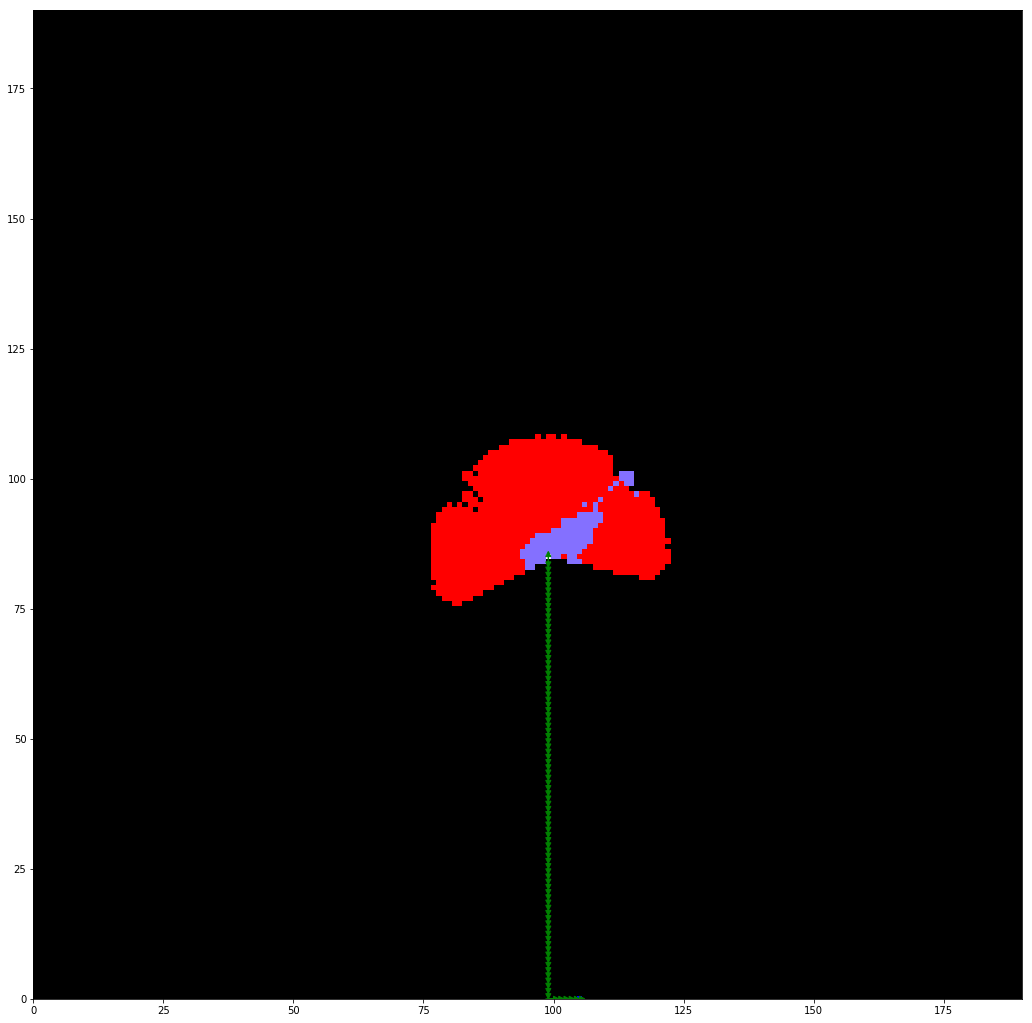

In [11]:
# # A * code taken from http://www.redblobgames.com/pathfinding/a-star/implementation.html#python
import a_star
from ast import literal_eval

multiplier = 10

# create a mini "world" map. The 4th layer indicate the areas that have been visited.
# 0 = area unexplored/uncharted
# 5 = area is an obstacle
# 6 = area has a rock sample
# 7 = area is navigable terrain
# 8 = extra indicator for other possible purposes
memory_map_mini = np.zeros([20 * multiplier, 20 * multiplier, 4], dtype=np.uint8)

# memory_map_mini = np.ones([20 * multiplier, 20 * multiplier, 4], dtype=np.uint8) * 255

with open('mymap.txt') as f:
    mainlist = [list(literal_eval(line)) for line in f][0]
    
top_map = np.asarray(mainlist)

#navigable_terrain
navigable_terrain_y, navigable_terrain_x = np.where(top_map[:,:] == 7)

# simulate visible terrain inside box. Flag for navigable terrain is 7
# memory_map_mini[5 * multiplier:11 * multiplier, 6 * multiplier: 10 * multiplier] = (132, 112, 255, 7)
# for nav_terrain in navigable_terrain:
#     memory_map_mini[nav_terrain[1], nav_terrain[0]] = (132, 112, 255, 7)

memory_map_mini[navigable_terrain_y, navigable_terrain_x] = (132, 112, 255, 7)

# plot obstacles on the map, color them red
# memory_map_mini[5 * multiplier:12 * multiplier, 5 * multiplier:6 * multiplier] = (255, 0, 0, 5)
# memory_map_mini[5 * multiplier:12 * multiplier, 10 * multiplier:11 * multiplier] = (255, 0, 0, 5)
# memory_map_mini[11 * multiplier:12 * multiplier, 5 * multiplier:11 * multiplier] = (255, 0, 0, 5)
# memory_map_mini[4 * multiplier:5 * multiplier, 6 * multiplier:9 * multiplier] = (255, 0, 0, 5)


with open('mywalls.txt') as f:
    wall_list = [list(literal_eval(line)) for line in f][0]

wall_coords = wall_list

# plot obstacles on the map
for obstacle_coords in wall_coords:
    memory_map_mini[obstacle_coords[1], obstacle_coords[0]] = (255, 0, 0, 5)

# create dummy rover position data for to_polar_coords with origin
# dummy_rover_xpos = 7 * multiplier
# dummy_rover_ypos = 6 * multiplier
dummy_rover_xpos = 99
dummy_rover_ypos = 85
rover_coords = (dummy_rover_xpos, dummy_rover_ypos)

# plot the rover location, color it white
memory_map_mini[dummy_rover_ypos, dummy_rover_xpos] = (255, 255, 255, 1)

# create dummy destinaton coordinates
# destination_x = 2 * multiplier
# destination_y = 2 * multiplier
destination_x = 105
destination_y = 0

memory_map_mini[destination_y, destination_x] = (0,0,255,8)
destination_coords = (destination_x, destination_y)





# guide on how to use A * results http://www.redblobgames.com/pathfinding/a-star/introduction.html#breadth-first-search
mygrid = a_star.GridWithWeights(20 * multiplier, 20 * multiplier)

# fetch the walls from the map
wall_pixels = np.where(memory_map_mini[:,:,3] == 5)

# convert numpy result to a list of tuples https://stackoverflow.com/a/10016379
# wall_coords = list(map(tuple, np.column_stack([wall_pixels[1], wall_pixels[0]])))

# assign walls to the grid
mygrid.walls = wall_coords

# get coordinates
came_from, cost_so_far = a_star.a_star_search(mygrid, rover_coords, destination_coords)
# a_star.draw_grid(mygrid, width=3, point_to=came_from, start=rover_coords, goal=destination_coords)
# print()
# a_star.draw_grid(mygrid, width=3, number=cost_so_far, start=rover_coords, goal=destination_coords)

# put coordinates in an ordered list
frontier = a_star.Queue()
frontier.put(rover_coords)
came_from[rover_coords] = None

current = destination_coords
path = [current]

try:
    while current != rover_coords:
       current = came_from[current]
       path.append(current)
except:
    
    print('error raised')
path.append(rover_coords) # optional
path.reverse() # optional


fig = plt.figure(figsize=(40,40))
plt.subplot(221)
plt.imshow(memory_map_mini[:, :, :3])
plt.ylim(0, 19 * multiplier)
plt.xlim(0, 19 * multiplier)


for index in range(0, len(path) - 1):
    
    current_x = path[index][0]
    current_y = path[index][1]
    
    next_x = path[index + 1][0]
    next_y = path[index + 1][1]
    
    # distance, angle = to_polar_coords_with_origin(dummy_rover_xpos, dummy_rover_ypos, unobstructed_x, unobstructed_y)
    distance, angle = to_polar_coords_with_origin(current_x, current_y, next_x, next_y)

    arrow_length = distance
    x_arrow = arrow_length * np.cos(angle)
    y_arrow = arrow_length * np.sin(angle)
    # plt.arrow(dummy_rover_xpos, dummy_rover_ypos, x_arrow, y_arrow, color='blue', head_width=.5, head_length=.5)
    plt.arrow(current_x, current_y, x_arrow, y_arrow, color='green', head_width=1, head_length=1)

## Write a function that will enable the rover to avoid an obstacle while heading to a destination

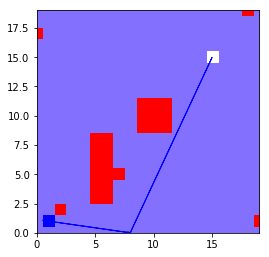

In [12]:
from collections import namedtuple

def sidestep_obstacle(origin_x, origin_y, destination_x, destination_y, map_data, navigable_flag, obstacle_flag):
    assert np.ndim(map_data) == 2
    
    # compute the distance between origin and all navigable points, and all navigable points to destinaion point    
    navigable_points = np.where(map_data == navigable_flag)
    
    distance_origin_to_midpoint = compute_distances(origin_x, origin_y, navigable_points[1], navigable_points[0])
    distance_midpoint_to_destination = compute_distances(navigable_points[1], navigable_points[0], destination_x, destination_y)
    
    combined_distance = distance_origin_to_midpoint + distance_midpoint_to_destination
    
    # find the shortest distance, but remember its original index
    
    original_indices = np.argsort(combined_distance)
    
    for original_index in original_indices:
        midpoint_x = np.array(navigable_points)[1, original_index]
        midpoint_y = np.array(navigable_points)[0, original_index]
        # check if either of the two paths are blocked
        obstacle_crossed_part_1 = obstacle_crossed_by_line(origin_x, origin_y, midpoint_x, midpoint_y, map_data, [obstacle_flag])
        if obstacle_crossed_part_1 is not False:
            # if the path was blocked 
            continue
        obstacle_crossed_part_2 = obstacle_crossed_by_line(midpoint_x, midpoint_y, destination_x, destination_y, map_data, [obstacle_flag])
        if obstacle_crossed_part_2 is not False:
            continue
            
        # if not blocked, compute the polar coordinates to be sent to the rover
        if (obstacle_crossed_part_1 is False) and (obstacle_crossed_part_2 is False):
            
            Path_guide = namedtuple("Path_guide", ["x", "y", "midpoint_distance", "midpoint_angle", "destination_distance", "destination_angle"])
            midpoint_distance, midpoint_angle = to_polar_coords_with_origin(origin_x, origin_y, midpoint_x, midpoint_y )
            destination_distance, destination_angle = to_polar_coords_with_origin(midpoint_x, midpoint_y, destination_x, destination_y)            
            path_guide = Path_guide(midpoint_x, midpoint_y, midpoint_distance, midpoint_angle, destination_distance, destination_angle)
            # if both are clear, then return the path guide
            return path_guide
    # if there are no clear paths, then return False
    return False

# create a mini "world" map. The 4th layer indicate the areas that have been visited.
# 0 = area unexplored/uncharted
# 5 = area is an obstacle
# 6 = area has a rock sample
# 7 = area is navigable terrain
# 8 = extra indicator for other possible purposes
memory_map_mini = np.zeros([20, 20, 4], dtype=np.uint8)

navigable_flag = 7
obstacle_flag = 5

# set all points as navigable
memory_map_mini[:, :] = (132, 112, 255, navigable_flag)

# plot obstacles on the map, color them red
memory_map_mini[9:12, 9:12] = (255, 0, 0, obstacle_flag)
memory_map_mini[19, 18] = (255, 0, 0, obstacle_flag)
memory_map_mini[5, 7] = (255, 0, 0, obstacle_flag)
memory_map_mini[2, 2] = (255, 0, 0, obstacle_flag)
memory_map_mini[1, 19] = (255, 0, 0, obstacle_flag)
memory_map_mini[17, 0] = (255, 0, 0, obstacle_flag)
memory_map_mini[3:9, 5:7] = (255, 0, 0, obstacle_flag)

# create dummy rover position data for to_polar_coords with origin
dummy_rover_xpos = 15
dummy_rover_ypos = 15

# plot the rover location, color it white
memory_map_mini[dummy_rover_ypos, dummy_rover_xpos] = (255, 255, 255, 1)

# create dummy destinaton coordinates
destination_x = 1
destination_y = 1

memory_map_mini[destination_y, destination_x] = (0,0,255,8)

path_guide = sidestep_obstacle(dummy_rover_xpos, dummy_rover_ypos, destination_x, destination_y, memory_map_mini[:,:,3], navigable_flag, obstacle_flag)
    
    
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(memory_map_mini[:, :, :3])
plt.ylim(0, 19)
plt.xlim(0, 19)

distance, angle = to_polar_coords_with_origin(dummy_rover_xpos, dummy_rover_ypos, path_guide.x, path_guide.y)

arrow_length = path_guide.midpoint_distance
x_arrow = arrow_length * np.cos(path_guide.midpoint_angle)
y_arrow = arrow_length * np.sin(path_guide.midpoint_angle)
plt.arrow(dummy_rover_xpos, dummy_rover_ypos, x_arrow, y_arrow, color='blue', head_width=.5, head_length=.5)

distance2, angle2 = to_polar_coords_with_origin(path_guide.x, path_guide.y, destination_x, destination_y)

arrow_length2 = path_guide.destination_distance
x_arrow2 = arrow_length2 * np.cos(path_guide.destination_angle)
y_arrow2 = arrow_length2 * np.sin(path_guide.destination_angle)
plt.arrow(path_guide.x, path_guide.y, x_arrow2, y_arrow2, color='blue', head_width=.5, head_length=.5)


## Write a helper function that can identify and return a pixel's value along with the values of its surrounding pixels

[[5 5 7]
 [5 1 7]
 [5 7 7]]
[[5 5 7 7 7]
 [5 5 5 7 7]
 [5 5 1 7 7]
 [5 5 7 7 7]
 [5 5 7 7 7]]


(0, 19)

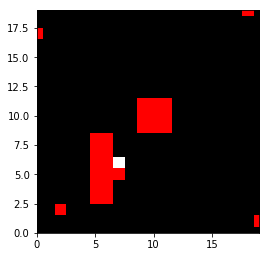

In [76]:
def get_surrounding_values(x_pixel, y_pixel, map_data, radius=1):
    assert np.ndim(map_data) == 2
    surrounding_pixels = map_data[(y_pixel - radius):(y_pixel + radius + 1), (x_pixel - radius): (x_pixel + radius + 1)]
    return surrounding_pixels

# create a mini "world" map. The 4th layer indicate the areas that have been visited.
# 0 = area unexplored/uncharted
# 5 = area is an obstacle
# 6 = area has a rock sample
# 7 = area is navigable terrain
# 8 = extra indicator for other possible purposes
memory_map_mini = np.zeros([20, 20, 4], dtype=np.uint8)

navigable_flag = 7
obstacle_flag = 5

# set all points as navigable
memory_map_mini[:, :] = (0, 0, 0, navigable_flag)

# plot obstacles on the map, color them red
memory_map_mini[9:12, 9:12] = (255, 0, 0, obstacle_flag)
memory_map_mini[19, 18] = (255, 0, 0, obstacle_flag)
memory_map_mini[5, 7] = (255, 0, 0, obstacle_flag)
memory_map_mini[2, 2] = (255, 0, 0, obstacle_flag)
memory_map_mini[1, 19] = (255, 0, 0, obstacle_flag)
memory_map_mini[17, 0] = (255, 0, 0, obstacle_flag)
memory_map_mini[3:9, 5:7] = (255, 0, 0, obstacle_flag)

# create dummy rover position data for to_polar_coords with origin
dummy_rover_xpos = 7
dummy_rover_ypos = 6

memory_map_mini[dummy_rover_ypos, dummy_rover_xpos] = (255, 255, 255, 1)


print(get_surrounding_values(dummy_rover_xpos, dummy_rover_ypos, memory_map_mini[:,:,3]))
# Result should be 
# [[5 5 7]
#  [5 1 7]
#  [5 7 7]]
# Fives are the red pixels, sevens are the white pixels, and 1 is the white pixel. The reuslt is inverted due to the 
# fact that the 0,0 points of arrays are in the upper left hand corner

print(get_surrounding_values(dummy_rover_xpos, dummy_rover_ypos, memory_map_mini[:,:,3], 2))
# Result should be:
# [[5 5 7 7 7]
#  [5 5 5 7 7]
#  [5 5 1 7 7]
#  [5 5 7 7 7]
#  [5 5 7 7 7]]


fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(memory_map_mini[:, :, :3])
plt.ylim(0, 19)
plt.xlim(0, 19)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

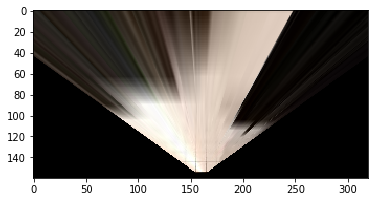

In [100]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'
DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'
DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'
DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'
DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'
DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'
DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'
DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'
DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'


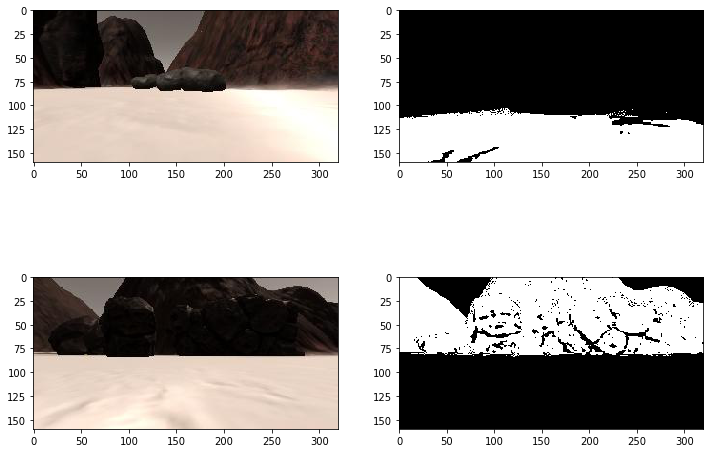

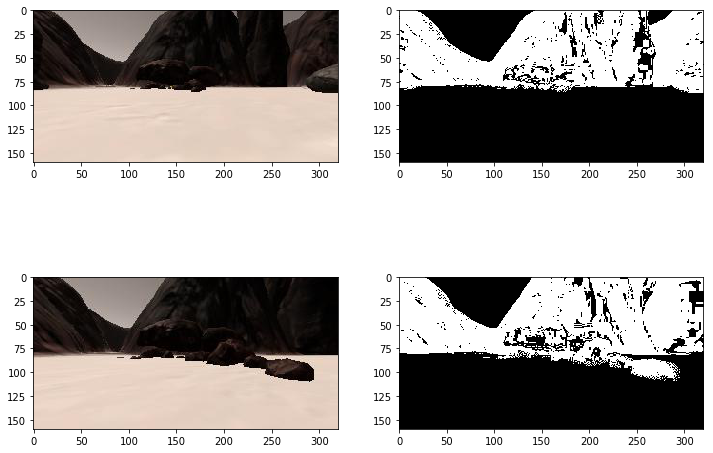

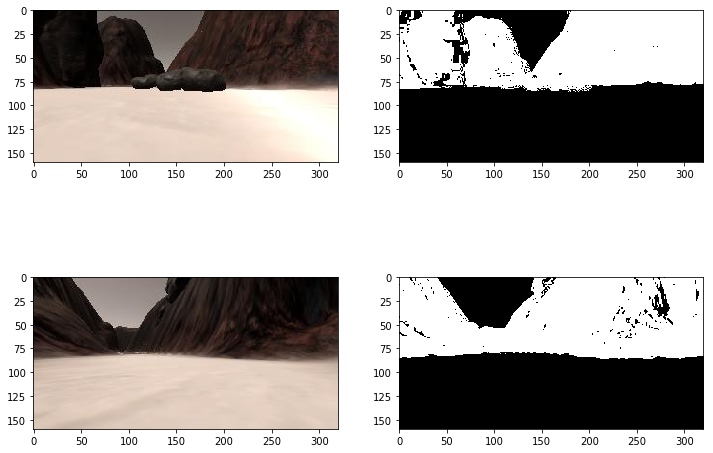

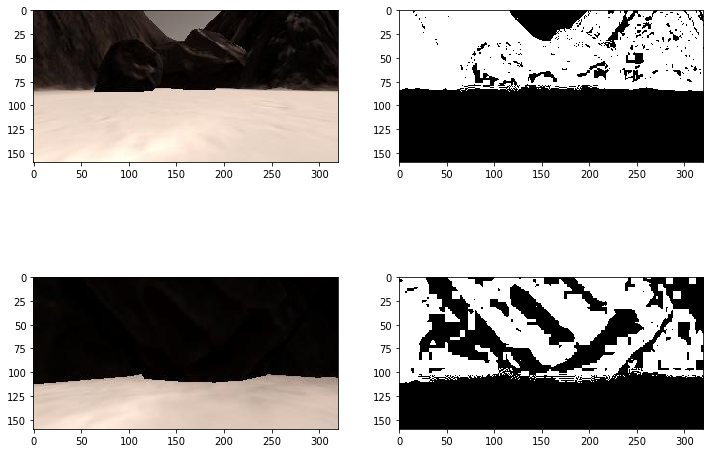

In [56]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select


def color_thresh_range(img, rgb_lower, rgb_higher):
    """
    takes an image input, and returns an image composed of colors within range
    :param img:
    :param rgb_lower: lower range
    :param rgb_higher: higher range
    :return:
    """
    color_select = np.zeros_like(img[:, :, 0])
    above_thresh = (img[:, :, 0] > rgb_lower[0]) \
                   & (img[:, :, 1] > rgb_lower[1]) \
                   & (img[:, :, 2] > rgb_lower[2])
    below_thresh = (img[:, :, 0] < rgb_higher[0]) \
                   & (img[:, :, 1] < rgb_higher[1]) \
                   & (img[:, :, 2] < rgb_higher[2])

    color_select[above_thresh & below_thresh] = 1
    return color_select


example_rock1 = mpimg.imread('../calibration_images/example_rock1.jpg')
example_rock2 = mpimg.imread('../calibration_images/example_rock2.jpg')

boulders = mpimg.imread('../../Rover_recordings/challenging_obstacles/boulders.jpg')
hanging_boulder = mpimg.imread('../../Rover_recordings/challenging_obstacles/hanging_boulder.jpg')
midroad_rocks = mpimg.imread('../../Rover_recordings/challenging_obstacles/midroad_rocks.jpg')
light_rocks = mpimg.imread('../../Rover_recordings/challenging_obstacles/light_rocks.jpg')
no_left_wall = mpimg.imread('../../Rover_recordings/challenging_obstacles/no_left_wall_5.jpg')
pass_through_boulders = mpimg.imread('../../Rover_recordings/challenging_obstacles/pass_through_boulders.jpg')
invisible_stones = mpimg.imread('../../Rover_recordings/challenging_obstacles/invisible_stones.jpg')


threshed = color_thresh(warped)
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

obstacle_lower_range = (0, 0, 0)
obstacle_upper_range = (100,100,100)

nav_lower_range = (160, 160, 160)
nav_upper_range = (255, 255, 255)

threshed_boulders = color_thresh_range(boulders, obstacle_lower_range, obstacle_upper_range)
threshed_hanging_boulder = color_thresh_range(hanging_boulder, obstacle_lower_range, obstacle_upper_range)
threshed_midroad_rocks = color_thresh_range(midroad_rocks, obstacle_lower_range, obstacle_upper_range)
threshed_light_rocks = color_thresh_range(light_rocks, obstacle_lower_range, obstacle_upper_range)
threshed_no_left_wall = color_thresh_range(no_left_wall, obstacle_lower_range, obstacle_upper_range)
threshed_pass_through_boulders = color_thresh_range(pass_through_boulders, obstacle_lower_range, obstacle_upper_range)
threshed_invisible_stones = color_thresh_range(invisible_stones, obstacle_lower_range, obstacle_upper_range)


nav_terrain = color_thresh_range(invisible_stones, nav_lower_range, nav_upper_range)

fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(light_rocks)
plt.subplot(222)
plt.imshow(nav_terrain, cmap='gray')
plt.subplot(223)
plt.imshow(boulders)
plt.subplot(224)
plt.imshow(threshed_boulders, cmap='gray')

fig2 = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(hanging_boulder)
plt.subplot(222)
plt.imshow(threshed_hanging_boulder, cmap='gray')
plt.subplot(223)
plt.imshow(midroad_rocks)
plt.subplot(224)
plt.imshow(threshed_midroad_rocks, cmap='gray')

fig3 = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(light_rocks)
plt.subplot(222)
\
plt.imshow(threshed_light_rocks, cmap='gray')
plt.subplot(223)
plt.imshow(no_left_wall)
plt.subplot(224)
plt.imshow(threshed_no_left_wall, cmap='gray')

fig4 = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(pass_through_boulders)
plt.subplot(222)
plt.imshow(threshed_pass_through_boulders, cmap='gray')
plt.subplot(223)
plt.imshow(invisible_stones)
plt.subplot(224)
plt.imshow(threshed_invisible_stones, cmap ='gray')

## Attempt thresholding operations with HSV

cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])
    images : it is the source image of type uint8 or float32. it should be given in square brackets, ie, "[img]".
    channels : it is also given in square brackets. It is the index of channel for which we calculate histogram. For example, if input is grayscale image, its value is [0]. For color image, you can pass [0], [1] or [2] to calculate histogram of blue, green or red channel respectively.
    mask : mask image. To find histogram of full image, it is given as "None". But if you want to find histogram of particular region of image, you have to create a mask image for that and give it as mask. (I will show an example later.)
    histSize : this represents our BIN count. Need to be given in square brackets. For full scale, we pass [256].
    ranges : this is our RANGE. Normally, it is [0,256].


[[[  0   0 100]]]


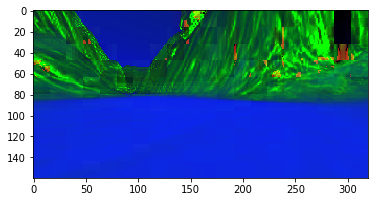

In [76]:
# Take each frame
invisible_stones = cv2.imread('../../Rover_recordings/challenging_obstacles/invisible_stones.jpg')


converted = cv2.cvtColor(no_left_wall, cv2.COLOR_RGB2HSV)
# Convert BGR to HSV
# hsv = cv2.cvtColor(invisible_stones, cv2.COLOR_BGR2HSV)

lower_blue = np.array([0,0,0])
upper_blue = np.array([50,50,50])

myimage = color_thresh_range(converted, lower_blue, upper_blue)

plt.imshow(converted)
# plt.imshow(myimage)
# # define range of blue color in HSV

green = np.uint8([[[100,100,100 ]]])
hsv_green = cv2.cvtColor(green,cv2.COLOR_RGB2HSV)
print (hsv_green)
# mask = cv2.inRange(hsv, lower_blue, upper_blue)

# # Bitwise-AND mask and original image
# res = cv2.bitwise_and(hsv,hsv, mask= mask)

# histo = cv2.calcHist(hsv, [3], None, [256], [0,256])

# # plt.imshow(myimage)
# # plt.imshow(mask)
# # plt.imshow(res)
# fig = plt.figure(figsize=(12,9))
# plt.subplot(221)
# # plt.ylim(0, 256)
# # plt.xlim(0, 256)
# plt.imshow(hsv)

# # img = cv2.imread('home.jpg',0)
 
#  # create a mask
# mask = np.zeros(invisible_stones.shape[:2], np.uint8)
# mask[100:300, 100:400] = 255
# masked_img = cv2.bitwise_and(light_rocks,light_rocks,mask = mask) 
#     # Calculate histogram with mask and without mask
#      # Check third argument for mask
# hist_full = cv2.calcHist([invisible_stones],[1],None,[256],[0,256])
# # hist_mask = cv2.calcHist([invisible_stones],[0],mask,[256],[0,256])
    
# plt.subplot(221), plt.imshow(light_rocks)
# plt.subplot(222), plt.imshow(mask,'gray')
# plt.subplot(223), plt.imshow(masked_img, 'gray')
# plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
# plt.xlim([0,256])
 
# plt.show()

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

DEBUG:PIL.Image:Error closing: 'NoneType' object has no attribute 'close'


160


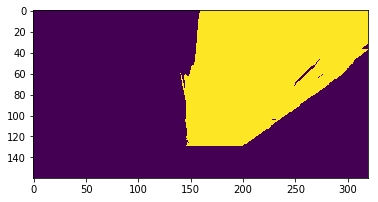

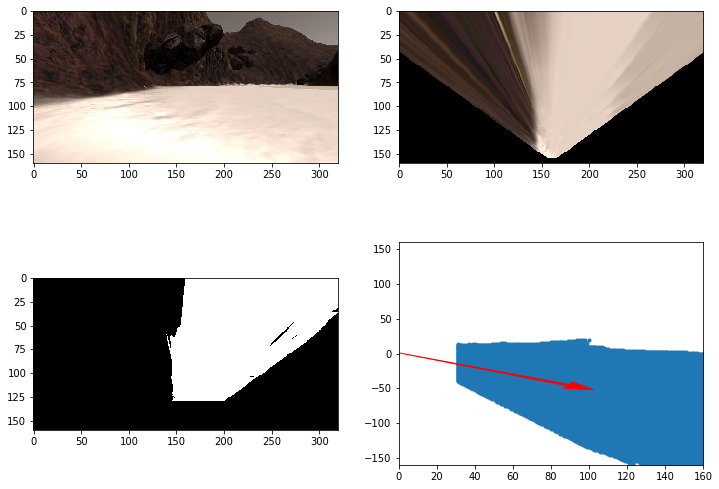

In [92]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

def to_polar_coords_with_origin(origin_x, origin_y, x_pixels, y_pixels):
    y_diffs = abs(y_pixels - origin_y)
    x_diffs = abs(x_pixels - origin_x)
    # Calculate the distances between the origin and the pixels
    dist = np.sqrt((y_diffs ** 2) + (x_diffs ** 2))
    angles = np.arctan2(y_diffs, x_diffs)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    yaw_rad = yaw * (np.pi / 180)
    cos_yaw = np.cos(yaw_rad)
    sin_yaw = np.sin(yaw_rad)

    # Apply a rotation
    xpix_rotated = (xpix * cos_yaw) - (ypix * sin_yaw)
    ypix_rotated = (xpix * sin_yaw) + (ypix * cos_yaw)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    x_world = np.int_(xpos + (xpix_rot / scale))
    y_world = np.int_(ypos + (ypix_rot / scale))

    xpix_translated = x_world
    ypix_translated = y_world
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

obstacle_terrain = threshed
bottom_offset = 30
print(warped.shape[0])
obstacle_terrain[warped.shape[0] - bottom_offset:warped.shape[0], :] = obstacle_terrain[warped.shape[0] - bottom_offset:warped.shape[0], :] * 0
plt.imshow(obstacle_terrain)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [103]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [9]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 1.75 s, sys: 150 ms, total: 1.9 s
Wall time: 2.3 s


100%|██████████| 283/283 [00:02<00:00, 136.79it/s]


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [11]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [12]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))